In [1]:
%matplotlib inline
import math
import numpy as np
import scipy as sp
import scipy.optimize
from scipy.stats import hypergeom, binom, norm, chi2
from scipy import special
from cryptorandom.cryptorandom import SHA256
from cryptorandom import sample
from permute.core import corr
from permute.npc import fisher
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [2]:
statewide_contests = np.array(["Governor", "Lieutenant Governor", "Secretary Of State", \
                               "Attorney General", "Commissioner Of Agriculture", \
                               "Commissioner Of Insurance", "State School Superintendent", "Commissioner Of Labor", \
                               "Public Service Commission, District 3 - Metro-Atlanta", \
                               "Public Service Commission, District 5 - Western"])


votes = pd.read_csv("../../Data/County_votes/undervotes_by_precinct.csv")
fulton = votes[votes.County == "FULTON"].copy()
fulton.head()

,County,Precinct_ID,Vote type,Total ballots,Contest,Ballots cast,Undervotes
5175,FULTON,10a,Absentee by Mail,46,Governor,46,0
5176,FULTON,10a,Advance in Person 1,774,Governor,774,0
5177,FULTON,10a,Advance in Person 2,29,Governor,29,0
5178,FULTON,10a,Advance in Person 3,95,Governor,94,1
5179,FULTON,10a,Election Day,670,Governor,670,0


In [3]:
turnout = pd.read_csv('../../Data/turnout_by_precinct.csv')
turnout["Precinct_name"] = turnout["Precinct_name"].str.strip()
turnout = turnout[turnout.County == "FULTON"].copy()
turnout.head()

,County,Precinct_ID,Precinct_name,Black_Male_reg,Black_Male_voted,Black_Female_reg,Black_Female_voted,Black_unknown_reg,Black_unknown_voted,White_Male_reg,...,Other_unknown_reg,Other_unknown_voted,Unknown_Male_reg,Unknown_Male_voted,Unknown_Female_reg,Unknown_Female_voted,Unknown_unknown_reg,Unknown_unknown_voted,Total_reg,Total_voted
103,FULTON,4,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
104,FULTON,1,NaN,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
105,FULTON,1a,01a,415,216,564,336,2,0,946,...,0,0,230,130,275,165,2,2,3647,2355
106,FULTON,1b,01b,404,171,503,264,1,0,1255,...,1,0,291,155,253,160,8,4,4248,2748
107,FULTON,1c,01c,645,151,689,286,1,0,93,...,0,0,104,25,98,34,5,0,1770,601


In [4]:
fulton["Vote type"].unique()

array(['Absentee by Mail', 'Advance in Person 1', 'Advance in Person 2',
       'Advance in Person 3', 'Election Day', 'Provisional'], dtype=object)

In [5]:
ff = fulton.loc[fulton["Contest"]=="Governor", ["Ballots cast", "Vote type"]]
mmm = ff["Vote type"].isin(fulton["Vote type"].unique())
np.sum(ff[mmm]["Ballots cast"] )

423788

In [6]:
fulton.Precinct_ID.nunique()

373

In [7]:
print(fulton.shape)
print(373*10*6)

(22380, 7)
22380


In [8]:
np.sum(fulton.loc[(fulton.Precinct_ID == "10j") & (fulton.Contest == "Governor"), "Ballots cast"])

465

In [9]:
#verify that every precinct has election day reported
fulton.loc[fulton["Vote type"]=="Election Day", "Precinct_ID"].nunique()

373

In [10]:
precincts = list(turnout.loc[turnout.Total_voted >= 10, "Precinct_ID"].unique())
print(len(precincts))
set(fulton["Precinct_ID"].unique()) - set(precincts)

364


{'3p2',
 'cp04a',
 'cp07b',
 'cp084',
 'sc07c',
 'sc08g',
 'sc08h',
 'sc16b',
 'sc17b',
 'uc01d'}

In [11]:
min_ballots = 10 # minimum number of ballots cast via each mode required to include the precinct

mode_mask = fulton['Vote type'].isin(['Advance in Person', 'Advance in Person 1', 'Advance in Person 2',
                                    'Advance in Person 3', 'Election Day', 'Absentee by Mail'])
dre_mask = fulton['Vote type'].isin(['Advance in Person', 'Advance in Person 1', 'Advance in Person 2',
                                    'Advance in Person 3', 'Election Day'])
ed_mask = fulton['Vote type'].isin(['Election Day'])
black_columns = ["Black_Male_reg", "Black_Female_reg", "Black_unknown_reg"]

# Keys are contests
# Items will be (diff_dict, ethnicity) which are themselves dicts
# containing precinct-level stats
data = {}


for c in statewide_contests:
    cont_mask = fulton['Contest'] == c
    diff_dict = {}
    ethnicity = {}
    for p in precincts:
        print("precinct", p, "contest", c)
        precinct_mask = fulton['Precinct_ID'] == p
        
        # Count number of ballots cast electronically and on paper in this contest & precinct
        ballots_electronic = fulton.loc[dre_mask & precinct_mask & cont_mask, "Total ballots"].sum()
        total_ballots = fulton.loc[mode_mask & precinct_mask & cont_mask, "Total ballots"].sum()
        ballots_paper = total_ballots - ballots_electronic
        
        # Exclude this precinct if too few ballots were cast
        if ballots_electronic < min_ballots or ballots_paper < min_ballots:
            continue
        
        # Count number of undervotes, electronic and paper, in this contest and precinct
        undervotes_electronic = fulton.loc[dre_mask & precinct_mask & cont_mask, "Undervotes"].sum()
        undervotes = fulton.loc[mode_mask & precinct_mask & cont_mask, "Undervotes"].sum()
        undervotes_paper = undervotes - undervotes_electronic
        
        # Calculate undervote rates
        if undervotes_electronic == 0 or ballots_electronic == 0:
            undervote_rate_electronic = 0
        else:
            undervote_rate_electronic = (undervotes_electronic/ballots_electronic)
            
        if undervotes_paper == 0 or ballots_paper == 0:
            undervote_rate_paper = 0
        else:
            undervote_rate_paper = (undervotes_paper/ballots_paper)
        
        # Add this precinct's difference in undervote rates to dict
        diff_dict[p] = undervote_rate_electronic - undervote_rate_paper
        
        # % Black registered voters in this precinct
        total_black_reg = turnout.loc[turnout.Precinct_ID == p, black_columns].sum().sum()   
        ethnicity[p] = float(total_black_reg/turnout.loc[turnout.Precinct_ID == p, "Total_reg"])
        
        print(p, diff_dict[p], ethnicity[p])
    data[c] = (diff_dict, ethnicity)

precinct 1a contest Governor
1a 0 0.2689882094872498
precinct 1b contest Governor
1b 0 0.2137476459510358
precinct 1c contest Governor
1c 0 0.7542372881355932
precinct 1d contest Governor
1d 0 0.558303886925795
precinct 1e contest Governor
1e 0 0.2727987421383648
precinct 1f contest Governor
precinct 1g contest Governor
1g 0 0.6109200343938092
precinct 1h contest Governor
1h 0 0.7424242424242424
precinct 1j contest Governor
1j -0.038461538461538464 0.7623126338329764
precinct 1p contest Governor
1p 0 0.8395061728395061
precinct 1r contest Governor
precinct 1s contest Governor
1s 0 0.8084349593495935
precinct 1t contest Governor
1t 0 0.5575170842824602
precinct 2a contest Governor
2a 0 0.1202113606340819
precinct 2b contest Governor
2b 0 0.5676537585421413
precinct 2c contest Governor
2c 0 0.3644278606965174
precinct 2d contest Governor
2d 0.000784313725490196 0.3199612403100775
precinct 2e contest Governor
2e 0 0.05920444033302498
precinct 2f1 contest Governor
2f1 0 0.0816557981287213


ap01c 0 0.09169407894736842
precinct ap01d contest Governor
ap01d 0 0.18129218900675023
precinct ap021 contest Governor
ap021 0 0.12385321100917432
precinct ap022 contest Governor
ap022 -0.011363636363636364 0.12731668009669622
precinct ap02b contest Governor
ap02b 0 0.09864603481624758
precinct ap03 contest Governor
precinct ap04a contest Governor
ap04a 0 0.0514829322887521
precinct ap04b contest Governor
ap04b 0 0.051685393258426963
precinct ap05 contest Governor
ap05 0 0.07154811715481171
precinct ap06 contest Governor
ap06 0 0.03319919517102616
precinct ap07a contest Governor
ap07a -0.010869565217391304 0.12104283054003724
precinct ap07b contest Governor
ap07b 0 0.07215332581736189
precinct ap09a contest Governor
ap09a 0 0.09931431099314311
precinct ap09b contest Governor
ap09b 0 0.1328125
precinct ap10 contest Governor
ap10 0 0.031067961165048542
precinct ap12a contest Governor
ap12a 0 0.19866666666666666
precinct ap12b contest Governor
ap12b 0.002421307506053269 0.245098039215686

sc23a -0.02881723438483598 0.8571428571428571
precinct sc23b contest Governor
sc23b 0.0037313432835820895 0.8220502901353965
precinct sc23c contest Governor
sc23c 0 0.8450363196125908
precinct sc27 contest Governor
sc27 0 0.8657894736842106
precinct sc29a contest Governor
sc29a 0 0.8610372340425532
precinct sc30a contest Governor
sc30a 0 0.8791946308724832
precinct sc30b contest Governor
sc30b 0.0019305019305019305 0.8474729241877257
precinct ss01 contest Governor
ss01 0 0.05432761826068994
precinct ss02a contest Governor
ss02a 0 0.16295707472178061
precinct ss02b contest Governor
ss02b 0 0.2776183644189383
precinct ss03 contest Governor
ss03 0 0.09824780976220275
precinct ss04 contest Governor
ss04 0 0.21525515743756787
precinct ss05 contest Governor
ss05 0 0.03099946552645644
precinct ss06 contest Governor
ss06 0 0.03411371237458194
precinct ss07a contest Governor
ss07a 0 0.037463976945244955
precinct ss07b contest Governor
ss07b 0.00267379679144385 0.12061068702290076
precinct ss07c

precinct 6l1 contest Lieutenant Governor
6l1 0.024232633279483037 0.08375378405650857
precinct 6l2 contest Lieutenant Governor
6l2 0.015765765765765764 0.0935754189944134
precinct 6n contest Lieutenant Governor
6n 0.02422480620155039 0.2629129827826896
precinct 6q contest Lieutenant Governor
precinct 6r contest Lieutenant Governor
6r 0.02177700348432056 0.15854823304680038
precinct 7a contest Lieutenant Governor
7a 0.004344319287998888 0.12408857682959762
precinct 7b contest Lieutenant Governor
7b 0.0016464883107521408 0.02435723951285521
precinct 7c contest Lieutenant Governor
7c -0.002850720903459239 0.11644603993717748
precinct 7d contest Lieutenant Governor
7d 0.01093732073884279 0.13717974581400041
precinct 7e contest Lieutenant Governor
7e 0.011648489693370637 0.16782911944202267
precinct 7f contest Lieutenant Governor
7f -0.009884117246080435 0.07991742848717193
precinct 7h contest Lieutenant Governor
7h -0.007708235922784048 0.06650943396226415
precinct 7j contest Lieutenant Go

ch05 0.036290322580645164 0.06839622641509434
precinct cp011 contest Lieutenant Governor
precinct cp012 contest Lieutenant Governor
cp012 -0.0383843329253366 0.5685595567867036
precinct cp01b contest Lieutenant Governor
cp01b 0.05116279069767442 0.46296296296296297
precinct cp02 contest Lieutenant Governor
cp02 0.0031309297912713446 0.6403897254207263
precinct cp04b contest Lieutenant Governor
precinct cp051 contest Lieutenant Governor
cp051 0.06213364595545135 0.8276631344116007
precinct cp05b contest Lieutenant Governor
precinct cp06a contest Lieutenant Governor
precinct cp07c contest Lieutenant Governor
precinct cp07d contest Lieutenant Governor
precinct cp07e contest Lieutenant Governor
precinct cp07f contest Lieutenant Governor
precinct cp081 contest Lieutenant Governor
precinct cp083 contest Lieutenant Governor
precinct cp08a contest Lieutenant Governor
precinct ep01a contest Lieutenant Governor
ep01a 0.027719298245614032 0.6053351573187414
precinct ep01b contest Lieutenant Gover

sc15 0.026272782455758068 0.8258468885241009
precinct sc16a contest Lieutenant Governor
sc16a 0.02588111186462188 0.8536144578313253
precinct sc17a contest Lieutenant Governor
precinct sc17c contest Lieutenant Governor
sc17c 0.06 0.8508914100486223
precinct sc18a contest Lieutenant Governor
sc18a 0.06493506493506493 0.8144329896907216
precinct sc18b contest Lieutenant Governor
sc18b 0.045146726862302484 0.8271428571428572
precinct sc18c contest Lieutenant Governor
sc18c 0.012585812356979406 0.8480040941658137
precinct sc19a contest Lieutenant Governor
precinct sc19b contest Lieutenant Governor
sc19b 0.06417910447761194 0.8428571428571429
precinct sc20 contest Lieutenant Governor
sc20 7.678132678132915e-05 0.8302127659574469
precinct sc211 contest Lieutenant Governor
sc211 -0.06369836571869772 0.8004201680672269
precinct sc212 contest Lieutenant Governor
sc212 0.04543053354463814 0.7790262172284644
precinct sc23a contest Lieutenant Governor
sc23a 0.06599286563614744 0.8571428571428571
p

precinct 4d contest Secretary Of State
4d 0.03513909224011713 0.8283362727807172
precinct 4f contest Secretary Of State
4f -0.00757745427398283 0.6147151898734177
precinct 4g contest Secretary Of State
precinct 4i contest Secretary Of State
4i -0.013282442748091604 0.6100828056502678
precinct 4j contest Secretary Of State
precinct 4k contest Secretary Of State
4k 0.03743760399334443 0.7789747399702823
precinct 4l contest Secretary Of State
4l 0.026159334126040427 0.7288135593220338
precinct 4m contest Secretary Of State
4m 0.014388489208633094 0.8214665249734325
precinct 4s contest Secretary Of State
4s 0.007836092887639284 0.8330598851517638
precinct 4t contest Secretary Of State
4t -0.04347237269772482 0.8164852255054432
precinct 4v contest Secretary Of State
4v -0.008354866494401376 0.8210037713954162
precinct 4w contest Secretary Of State
precinct 4x1 contest Secretary Of State
4x1 0.025302530253025302 0.792992162286768
precinct 4x2 contest Secretary Of State
4x2 0.0171428571428571

ap01a -0.03372565766996925 0.0879392212725546
precinct ap01b contest Secretary Of State
ap01b 0.01603206412825651 0.1665080875356803
precinct ap01c contest Secretary Of State
ap01c 0.0019822982956623526 0.09169407894736842
precinct ap01d contest Secretary Of State
ap01d 0.013806706114398421 0.18129218900675023
precinct ap021 contest Secretary Of State
ap021 -0.020684305079209542 0.12385321100917432
precinct ap022 contest Secretary Of State
ap022 -0.002293341579055865 0.12731668009669622
precinct ap02b contest Secretary Of State
ap02b 0.009478672985781991 0.09864603481624758
precinct ap03 contest Secretary Of State
precinct ap04a contest Secretary Of State
ap04a 0.018617021276595744 0.0514829322887521
precinct ap04b contest Secretary Of State
ap04b 0.021505376344086023 0.051685393258426963
precinct ap05 contest Secretary Of State
ap05 -0.01479623206499547 0.07154811715481171
precinct ap06 contest Secretary Of State
ap06 -0.004692341744134573 0.03319919517102616
precinct ap07a contest Se

precinct rw21 contest Secretary Of State
rw21 -0.0016270527881492268 0.09997118985883031
precinct rw22a contest Secretary Of State
rw22a 0.008368200836820083 0.25054769966142204
precinct sc01a contest Secretary Of State
precinct sc01b contest Secretary Of State
sc01b 0.009501187648456057 0.8408710217755444
precinct sc01c contest Secretary Of State
sc01c -0.00859254475657446 0.8589743589743589
precinct sc01d contest Secretary Of State
precinct sc02 contest Secretary Of State
sc02 0.017001545595054096 0.8616557734204793
precinct sc04 contest Secretary Of State
sc04 0.015 0.5277497477295661
precinct sc05a contest Secretary Of State
precinct sc05b contest Secretary Of State
sc05b -0.0689155404181311 0.8231548480463097
precinct sc05d contest Secretary Of State
sc05d 0.010014306151645207 0.8249359521776259
precinct sc05e contest Secretary Of State
sc05e -0.03326111889894227 0.7228177641653905
precinct sc07a contest Secretary Of State
sc07a 0.0018867233810082977 0.7560086192607326
precinct sc

3f 0.008411214953271028 0.29450261780104714
precinct 3g contest Attorney General
precinct 3h contest Attorney General
3h 0.056818181818181816 0.8207720588235294
precinct 3i contest Attorney General
3i 0.033582089552238806 0.17267441860465116
precinct 3l contest Attorney General
precinct 3m contest Attorney General
3m -0.09062213623867223 0.33225458468176916
precinct 3n contest Attorney General
3n 0.03200883002207505 0.7344144144144145
precinct 3p1a contest Attorney General
3p1a -0.018715967037757127 0.30733743409490333
precinct 3s contest Attorney General
precinct 3t contest Attorney General
3t 0.021645021645021644 0.7777161862527716
precinct 4a contest Attorney General
4a 0.03802281368821293 0.8316151202749141
precinct 4b contest Attorney General
4b -0.006912442396313362 0.8372093023255814
precinct 4c contest Attorney General
precinct 4d contest Attorney General
4d 0.03806734992679356 0.8283362727807172
precinct 4f contest Attorney General
4f -0.003098170959313175 0.6147151898734177
p

precinct 88888 contest Attorney General
precinct ap01a contest Attorney General
ap01a -0.023042364195421938 0.0879392212725546
precinct ap01b contest Attorney General
ap01b 0.01002004008016032 0.1665080875356803
precinct ap01c contest Attorney General
ap01c -0.0023187769731548517 0.09169407894736842
precinct ap01d contest Attorney General
ap01d 0.021696252465483234 0.18129218900675023
precinct ap021 contest Attorney General
ap021 0.016454352441613588 0.12385321100917432
precinct ap022 contest Attorney General
ap022 -0.0038308252593966877 0.12731668009669622
precinct ap02b contest Attorney General
ap02b 0.009478672985781991 0.09864603481624758
precinct ap03 contest Attorney General
precinct ap04a contest Attorney General
ap04a -0.006702127659574468 0.0514829322887521
precinct ap04b contest Attorney General
ap04b 0.017921146953405017 0.051685393258426963
precinct ap05 contest Attorney General
ap05 -0.011607004566767264 0.07154811715481171
precinct ap06 contest Attorney General
ap06 0.016

precinct rw11a contest Attorney General
rw11a 0.002805710738671632 0.13121406831247887
precinct rw12 contest Attorney General
rw12 0.017652909000497267 0.0525246209160544
precinct rw13 contest Attorney General
rw13 0.017691659646166806 0.09081658611040448
precinct rw16 contest Attorney General
rw16 -0.002734296608468795 0.08883374689826302
precinct rw17 contest Attorney General
rw17 0.01710914454277286 0.15876551065860642
precinct rw19 contest Attorney General
rw19 0.01400147383935151 0.05385329619312906
precinct rw20 contest Attorney General
rw20 -0.0007847686638460492 0.09703703703703703
precinct rw21 contest Attorney General
rw21 0.002209877667486265 0.09997118985883031
precinct rw22a contest Attorney General
rw22a 0.014225941422594143 0.25054769966142204
precinct sc01a contest Attorney General
precinct sc01b contest Attorney General
sc01b 0.010292953285827395 0.8408710217755444
precinct sc01c contest Attorney General
sc01c -0.03627166074695942 0.8589743589743589
precinct sc01d cont

2b -0.015108744466542635 0.5676537585421413
precinct 2c contest Commissioner Of Agriculture
2c 0.043029259896729774 0.3644278606965174
precinct 2d contest Commissioner Of Agriculture
2d 0.004871639377400445 0.3199612403100775
precinct 2e contest Commissioner Of Agriculture
2e -0.0005705986098142948 0.05920444033302498
precinct 2f1 contest Commissioner Of Agriculture
2f1 -0.019721010310488524 0.0816557981287213
precinct 2f2 contest Commissioner Of Agriculture
2f2 0.02947845804988662 0.33153928955866524
precinct 2g contest Commissioner Of Agriculture
2g 0.008495102404274264 0.14512134720158495
precinct 2j contest Commissioner Of Agriculture
2j -0.027166518781425612 0.077217125382263
precinct 2k contest Commissioner Of Agriculture
2k 0.00730609768429568 0.08662790697674419
precinct 2l1 contest Commissioner Of Agriculture
2l1 -0.0021898611061689707 0.13781877373846987
precinct 2l2 contest Commissioner Of Agriculture
2l2 -0.05103185284881112 0.11060802069857698
precinct 2s contest Commissio

precinct 10a contest Commissioner Of Agriculture
10a -0.0013864241348713405 0.8683181225554107
precinct 10b contest Commissioner Of Agriculture
10b 0.022351163636938946 0.8552366565961732
precinct 10c contest Commissioner Of Agriculture
10c 0.03279212792127921 0.8725099601593626
precinct 10d contest Commissioner Of Agriculture
10d 0.021000417226832317 0.8620618129018875
precinct 10e contest Commissioner Of Agriculture
10e 0.03413654618473896 0.8307543520309478
precinct 10f contest Commissioner Of Agriculture
10f 0.009054634745242485 0.849956634865568
precinct 10g contest Commissioner Of Agriculture
10g 0.0028047301394784688 0.8682170542635659
precinct 10h1 contest Commissioner Of Agriculture
precinct 10h2 contest Commissioner Of Agriculture
10h2 0.052200614124872056 0.8510721247563353
precinct 10i contest Commissioner Of Agriculture
10i 0.05 0.8376068376068376
precinct 10j contest Commissioner Of Agriculture
10j 0.04241071428571429 0.8192668371696504
precinct 10k contest Commissioner O

precinct jc01 contest Commissioner Of Agriculture
jc01 -0.04802083977049632 0.08447573175250092
precinct jc02 contest Commissioner Of Agriculture
jc02 -0.014256046090976082 0.12276119402985075
precinct jc03a contest Commissioner Of Agriculture
jc03a -0.04764492753623188 0.115
precinct jc03b contest Commissioner Of Agriculture
jc03b -0.0010688081344965017 0.13673088875077688
precinct jc04a contest Commissioner Of Agriculture
jc04a 0.00804920941114494 0.08397291196388262
precinct jc04b contest Commissioner Of Agriculture
precinct jc05 contest Commissioner Of Agriculture
jc05 -0.05203484902733023 0.12146773513285533
precinct jc06 contest Commissioner Of Agriculture
jc06 -0.018820708773507156 0.1149932157394844
precinct jc07 contest Commissioner Of Agriculture
jc07 0.006183525025383246 0.11234212275648128
precinct jc08 contest Commissioner Of Agriculture
jc08 0.026374859708193043 0.10118043844856661
precinct jc09 contest Commissioner Of Agriculture
jc09 0.007355900951787359 0.1340079730144

sc18c 0.012967200610221205 0.8480040941658137
precinct sc19a contest Commissioner Of Agriculture
precinct sc19b contest Commissioner Of Agriculture
sc19b 0.025373134328358207 0.8428571428571429
precinct sc20 contest Commissioner Of Agriculture
sc20 0.012285012285012284 0.8302127659574469
precinct sc211 contest Commissioner Of Agriculture
sc211 -0.1468922918543302 0.8004201680672269
precinct sc212 contest Commissioner Of Agriculture
sc212 -0.010122642452277952 0.7790262172284644
precinct sc23a contest Commissioner Of Agriculture
sc23a 0.02140309155766944 0.8571428571428571
precinct sc23b contest Commissioner Of Agriculture
sc23b 0.014925373134328358 0.8220502901353965
precinct sc23c contest Commissioner Of Agriculture
sc23c -0.04451476793248945 0.8450363196125908
precinct sc27 contest Commissioner Of Agriculture
sc27 0.002363184079601989 0.8657894736842106
precinct sc29a contest Commissioner Of Agriculture
sc29a 0.02911306702775897 0.8610372340425532
precinct sc30a contest Commissioner 

4m 0.01079136690647482 0.8214665249734325
precinct 4s contest Commissioner Of Insurance
4s 0.015333749869832346 0.8330598851517638
precinct 4t contest Commissioner Of Insurance
4t -0.034669555796316365 0.8164852255054432
precinct 4v contest Commissioner Of Insurance
4v 0.001119724375538332 0.8210037713954162
precinct 4w contest Commissioner Of Insurance
precinct 4x1 contest Commissioner Of Insurance
4x1 -0.050520436659050524 0.792992162286768
precinct 4x2 contest Commissioner Of Insurance
4x2 -0.0451948051948052 0.7791907514450868
precinct 5a1 contest Commissioner Of Insurance
5a1 0.025362318840579712 0.17004898530440868
precinct 5a2 contest Commissioner Of Insurance
5a2 0.026028110359187923 0.2811559301625527
precinct 5b contest Commissioner Of Insurance
5b 0.015989592076548598 0.6351028216164515
precinct 5c contest Commissioner Of Insurance
precinct 5d contest Commissioner Of Insurance
precinct 5f contest Commissioner Of Insurance
precinct 5j contest Commissioner Of Insurance
5j 0.01

12j -0.07054942266209872 0.8520566885585897
precinct 12k contest Commissioner Of Insurance
12k 0.03604358759430008 0.7221750212404418
precinct 12l contest Commissioner Of Insurance
precinct 12m contest Commissioner Of Insurance
12m -0.028367605869820223 0.8426610348468849
precinct 12n contest Commissioner Of Insurance
precinct 12s contest Commissioner Of Insurance
12s -0.010401370533529124 0.8233867054827754
precinct 88888 contest Commissioner Of Insurance
precinct ap01a contest Commissioner Of Insurance
ap01a -0.020867782712675094 0.0879392212725546
precinct ap01b contest Commissioner Of Insurance
ap01b -0.04462257849031396 0.1665080875356803
precinct ap01c contest Commissioner Of Insurance
ap01c -0.007504937458854508 0.09169407894736842
precinct ap01d contest Commissioner Of Insurance
ap01d 0.02564102564102564 0.18129218900675023
precinct ap021 contest Commissioner Of Insurance
ap021 0.004785235995427076 0.12385321100917432
precinct ap022 contest Commissioner Of Insurance
ap022 0.010

ml072 0.01701093560145808 0.04666666666666667
precinct ml07a contest Commissioner Of Insurance
ml07a 0.024282560706401765 0.030848329048843187
precinct mp01 contest Commissioner Of Insurance
mp01 0.019933554817275746 0.016
precinct pa01 contest Commissioner Of Insurance
pa01 -0.05849541129914962 0.5891107078039928
precinct rw01 contest Commissioner Of Insurance
rw01 -0.0004924227965034146 0.05312683787492648
precinct rw02 contest Commissioner Of Insurance
rw02 0.010181973335697583 0.05938184473107812
precinct rw03 contest Commissioner Of Insurance
rw03 -0.00788158400615148 0.17620182757250696
precinct rw04 contest Commissioner Of Insurance
rw04 0.012403100775193798 0.04374364191251272
precinct rw05 contest Commissioner Of Insurance
rw05 -0.022070052711956254 0.2434881087202718
precinct rw06 contest Commissioner Of Insurance
rw06 0.008679982896585425 0.1177036561898653
precinct rw07a contest Commissioner Of Insurance
rw07a 0.032208588957055216 0.4381586245146977
precinct rw07b contest C

ss20 0.01738334858188472 0.29244482173174874
precinct ss22 contest Commissioner Of Insurance
ss22 -0.007226370973825152 0.25665704202759065
precinct ss26 contest Commissioner Of Insurance
ss26 0.01825442099258414 0.42775393419170243
precinct ss29a contest Commissioner Of Insurance
ss29a 0.0033384337181805515 0.14452054794520547
precinct ss31 contest Commissioner Of Insurance
ss31 -0.00596264367816092 0.13812154696132597
precinct uc01a contest Commissioner Of Insurance
uc01a 0.015625 0.8343094192288921
precinct uc01b contest Commissioner Of Insurance
precinct uc01e contest Commissioner Of Insurance
precinct uc02a contest Commissioner Of Insurance
uc02a 0.016389491443721378 0.8088845496704906
precinct uc02b contest Commissioner Of Insurance
precinct uc031 contest Commissioner Of Insurance
uc031 0.0019138232720909906 0.7014814814814815
precinct uc032 contest Commissioner Of Insurance
uc032 0.028409090909090908 0.7161716171617162
precinct 1a contest State School Superintendent
1a -0.016160

7j -0.017986834378959725 0.12
precinct 7m contest State School Superintendent
7m -0.023886524822695033 0.1833009708737864
precinct 7n contest State School Superintendent
7n 0.007420955264043055 0.33914559721011334
precinct 8a contest State School Superintendent
8a -0.016540226062074677 0.1260239445494644
precinct 8b contest State School Superintendent
8b -0.015682324637166848 0.04891762721394433
precinct 8c contest State School Superintendent
8c 0.0014256349048471575 0.017310252996005325
precinct 8d contest State School Superintendent
8d 0.03536067892503536 0.008166969147005444
precinct 8e contest State School Superintendent
8e -0.01176155050211928 0.03560490045941807
precinct 8f1 contest State School Superintendent
8f1 -0.003100498930862436 0.01683348498635123
precinct 8g contest State School Superintendent
8g -0.014801061007957559 0.18765664160401002
precinct 8h contest State School Superintendent
8h 0.010781194768469428 0.040944300995942456
precinct 8j contest State School Superinte

ep03b 0.01282051282051282 0.8169291338582677
precinct ep04a contest State School Superintendent
ep04a 0.012142577359968664 0.8340726137670446
precinct ep04b contest State School Superintendent
ep04b 0.00933786078098472 0.8304856115107914
precinct fa01a contest State School Superintendent
fa01a 0.005069972011195523 0.7384733606557377
precinct fa01b contest State School Superintendent
fa01b -0.01529497093906515 0.683028129129696
precinct fa01c contest State School Superintendent
fa01c 0.010582010582010581 0.7721179624664879
precinct hp01 contest State School Superintendent
hp01 -0.05912845254266398 0.4439822518025513
precinct jc01 contest State School Superintendent
jc01 -0.02426552960619616 0.08447573175250092
precinct jc02 contest State School Superintendent
jc02 -0.01032357473035439 0.12276119402985075
precinct jc03a contest State School Superintendent
jc03a -0.050362318840579706 0.115
precinct jc03b contest State School Superintendent
jc03b -0.030677682130683455 0.13673088875077688
p

precinct 3f contest Commissioner Of Labor
3f 0.02149532710280374 0.29450261780104714
precinct 3g contest Commissioner Of Labor
precinct 3h contest Commissioner Of Labor
3h 0.048295454545454544 0.8207720588235294
precinct 3i contest Commissioner Of Labor
3i -0.06633499170812604 0.17267441860465116
precinct 3l contest Commissioner Of Labor
precinct 3m contest Commissioner Of Labor
3m -0.037776193870277974 0.33225458468176916
precinct 3n contest Commissioner Of Labor
3n 0.024282560706401765 0.7344144144144145
precinct 3p1a contest Commissioner Of Labor
3p1a 0.0001314615059953353 0.30733743409490333
precinct 3s contest Commissioner Of Labor
precinct 3t contest Commissioner Of Labor
3t 0.03318903318903319 0.7777161862527716
precinct 4a contest Commissioner Of Labor
4a -0.03244613434727503 0.8316151202749141
precinct 4b contest Commissioner Of Labor
4b 0.003456221198156681 0.8372093023255814
precinct 4c contest Commissioner Of Labor
precinct 4d contest Commissioner Of Labor
4d 0.043923865300

precinct 12a contest Commissioner Of Labor
12a 0.0007152914671923402 0.7025443895295626
precinct 12d contest Commissioner Of Labor
12d -0.035416666666666666 0.8205689277899344
precinct 12e1 contest Commissioner Of Labor
12e1 -0.060451977401129946 0.7941336230309615
precinct 12f contest Commissioner Of Labor
precinct 12g contest Commissioner Of Labor
precinct 12h1 contest Commissioner Of Labor
precinct 12h2 contest Commissioner Of Labor
12h2 0.03634751773049645 0.842560553633218
precinct 12i contest Commissioner Of Labor
12i -0.02906976744186046 0.8570135746606334
precinct 12j contest Commissioner Of Labor
12j -0.10602715391447787 0.8520566885585897
precinct 12k contest Commissioner Of Labor
12k -0.007734511925626762 0.7221750212404418
precinct 12l contest Commissioner Of Labor
precinct 12m contest Commissioner Of Labor
12m -0.0057692768055921315 0.8426610348468849
precinct 12n contest Commissioner Of Labor
precinct 12s contest Commissioner Of Labor
12s -0.017009300048947622 0.823386705

pa01 -0.1180011787488423 0.5891107078039928
precinct rw01 contest Commissioner Of Labor
rw01 -0.009040475372498122 0.05312683787492648
precinct rw02 contest Commissioner Of Labor
rw02 0.003723693105626546 0.05938184473107812
precinct rw03 contest Commissioner Of Labor
rw03 -0.013360246059207999 0.17620182757250696
precinct rw04 contest Commissioner Of Labor
rw04 0.0027484143763213537 0.04374364191251272
precinct rw05 contest Commissioner Of Labor
rw05 -0.03832701118281689 0.2434881087202718
precinct rw06 contest Commissioner Of Labor
rw06 0.015277014232484272 0.1177036561898653
precinct rw07a contest Commissioner Of Labor
rw07a 0.02147239263803681 0.4381586245146977
precinct rw07b contest Commissioner Of Labor
precinct rw08 contest Commissioner Of Labor
rw08 -0.07303532114482626 0.04300168634064081
precinct rw09 contest Commissioner Of Labor
rw09 -0.016562395427068513 0.04789391575663027
precinct rw10 contest Commissioner Of Labor
rw10 -0.00634085288618131 0.03680981595092025
precinct 

ss29a 0.027651895073613923 0.14452054794520547
precinct ss31 contest Commissioner Of Labor
ss31 -0.023886494252873564 0.13812154696132597
precinct uc01a contest Commissioner Of Labor
uc01a 0.014423076923076924 0.8343094192288921
precinct uc01b contest Commissioner Of Labor
precinct uc01e contest Commissioner Of Labor
precinct uc02a contest Commissioner Of Labor
uc02a -0.0017181104764937283 0.8088845496704906
precinct uc02b contest Commissioner Of Labor
precinct uc031 contest Commissioner Of Labor
uc031 0.001038932633420822 0.7014814814814815
precinct uc032 contest Commissioner Of Labor
uc032 0.022727272727272728 0.7161716171617162
precinct 1a contest Public Service Commission, District 3 - Metro-Atlanta
1a -0.0022720609791849894 0.2689882094872498
precinct 1b contest Public Service Commission, District 3 - Metro-Atlanta
1b -0.016035305942957656 0.2137476459510358
precinct 1c contest Public Service Commission, District 3 - Metro-Atlanta
1c 0.01692047377326565 0.7542372881355932
precinct

precinct 8a contest Public Service Commission, District 3 - Metro-Atlanta
8a -0.012269226099030184 0.1260239445494644
precinct 8b contest Public Service Commission, District 3 - Metro-Atlanta
8b -0.057750617116435386 0.04891762721394433
precinct 8c contest Public Service Commission, District 3 - Metro-Atlanta
8c 0.030634573304157548 0.017310252996005325
precinct 8d contest Public Service Commission, District 3 - Metro-Atlanta
8d 0.01074468349090548 0.008166969147005444
precinct 8e contest Public Service Commission, District 3 - Metro-Atlanta
8e -0.0024138658787527037 0.03560490045941807
precinct 8f1 contest Public Service Commission, District 3 - Metro-Atlanta
8f1 -0.005723449750534567 0.01683348498635123
precinct 8g contest Public Service Commission, District 3 - Metro-Atlanta
8g -0.008134394341290891 0.18765664160401002
precinct 8h contest Public Service Commission, District 3 - Metro-Atlanta
8h -0.012422360248447208 0.040944300995942456
precinct 8j contest Public Service Commission,

precinct ch05 contest Public Service Commission, District 3 - Metro-Atlanta
ch05 0.008064516129032258 0.06839622641509434
precinct cp011 contest Public Service Commission, District 3 - Metro-Atlanta
precinct cp012 contest Public Service Commission, District 3 - Metro-Atlanta
cp012 -0.050624235006119955 0.5685595567867036
precinct cp01b contest Public Service Commission, District 3 - Metro-Atlanta
cp01b 0.027906976744186046 0.46296296296296297
precinct cp02 contest Public Service Commission, District 3 - Metro-Atlanta
cp02 -0.07533206831119545 0.6403897254207263
precinct cp04b contest Public Service Commission, District 3 - Metro-Atlanta
precinct cp051 contest Public Service Commission, District 3 - Metro-Atlanta
cp051 0.026963657678780773 0.8276631344116007
precinct cp05b contest Public Service Commission, District 3 - Metro-Atlanta
precinct cp06a contest Public Service Commission, District 3 - Metro-Atlanta
precinct cp07c contest Public Service Commission, District 3 - Metro-Atlanta
p

rw07a 0.015337423312883436 0.4381586245146977
precinct rw07b contest Public Service Commission, District 3 - Metro-Atlanta
precinct rw08 contest Public Service Commission, District 3 - Metro-Atlanta
rw08 -0.0500462652755177 0.04300168634064081
precinct rw09 contest Public Service Commission, District 3 - Metro-Atlanta
rw09 -0.017769815286287665 0.04789391575663027
precinct rw10 contest Public Service Commission, District 3 - Metro-Atlanta
rw10 -0.0379697207310453 0.03680981595092025
precinct rw11a contest Public Service Commission, District 3 - Metro-Atlanta
rw11a -0.0018373680943513347 0.13121406831247887
precinct rw12 contest Public Service Commission, District 3 - Metro-Atlanta
rw12 -0.011063516143444557 0.0525246209160544
precinct rw13 contest Public Service Commission, District 3 - Metro-Atlanta
rw13 -0.003902163548330357 0.09081658611040448
precinct rw16 contest Public Service Commission, District 3 - Metro-Atlanta
rw16 0.008027292795504716 0.08883374689826302
precinct rw17 conte

ss22 -0.02000452591083956 0.25665704202759065
precinct ss26 contest Public Service Commission, District 3 - Metro-Atlanta
ss26 0.019965772960638905 0.42775393419170243
precinct ss29a contest Public Service Commission, District 3 - Metro-Atlanta
ss29a 0.0033384337181805515 0.14452054794520547
precinct ss31 contest Public Service Commission, District 3 - Metro-Atlanta
ss31 -0.014008620689655173 0.13812154696132597
precinct uc01a contest Public Service Commission, District 3 - Metro-Atlanta
uc01a 0.01622596153846154 0.8343094192288921
precinct uc01b contest Public Service Commission, District 3 - Metro-Atlanta
precinct uc01e contest Public Service Commission, District 3 - Metro-Atlanta
precinct uc02a contest Public Service Commission, District 3 - Metro-Atlanta
uc02a -0.009446290805123818 0.8088845496704906
precinct uc02b contest Public Service Commission, District 3 - Metro-Atlanta
precinct uc031 contest Public Service Commission, District 3 - Metro-Atlanta
uc031 0.0027887139107611557 0.

precinct 8b contest Public Service Commission, District 5 - Western
8b -0.054499339828929586 0.04891762721394433
precinct 8c contest Public Service Commission, District 5 - Western
8c 0.02735229759299781 0.017310252996005325
precinct 8d contest Public Service Commission, District 5 - Western
8d 0.012159110647906896 0.008166969147005444
precinct 8e contest Public Service Commission, District 5 - Western
8e 0.006291879913470161 0.03560490045941807
precinct 8f1 contest Public Service Commission, District 5 - Western
8f1 0.014982181040627228 0.01683348498635123
precinct 8g contest Public Service Commission, District 5 - Western
8g 0.006525198938992043 0.18765664160401002
precinct 8h contest Public Service Commission, District 5 - Western
8h -0.007195879412210272 0.040944300995942456
precinct 8j contest Public Service Commission, District 5 - Western
8j 0.02390859127909991 0.10844115834873691
precinct 8k contest Public Service Commission, District 5 - Western
8k -0.048729446935724965 0.0940

cp051 0.01992966002344666 0.8276631344116007
precinct cp05b contest Public Service Commission, District 5 - Western
precinct cp06a contest Public Service Commission, District 5 - Western
precinct cp07c contest Public Service Commission, District 5 - Western
precinct cp07d contest Public Service Commission, District 5 - Western
precinct cp07e contest Public Service Commission, District 5 - Western
precinct cp07f contest Public Service Commission, District 5 - Western
precinct cp081 contest Public Service Commission, District 5 - Western
precinct cp083 contest Public Service Commission, District 5 - Western
precinct cp08a contest Public Service Commission, District 5 - Western
precinct ep01a contest Public Service Commission, District 5 - Western
ep01a -0.008070175438596491 0.6053351573187414
precinct ep01b contest Public Service Commission, District 5 - Western
ep01b -0.006985871271585559 0.7360703812316716
precinct ep02a contest Public Service Commission, District 5 - Western
ep02a 0.0

rw12 -0.009074455974374444 0.0525246209160544
precinct rw13 contest Public Service Commission, District 5 - Western
rw13 0.004559467491228229 0.09081658611040448
precinct rw16 contest Public Service Commission, District 5 - Western
rw16 0.0038882199478225965 0.08883374689826302
precinct rw17 contest Public Service Commission, District 5 - Western
rw17 0.004386302424009234 0.15876551065860642
precinct rw19 contest Public Service Commission, District 5 - Western
rw19 -0.028261865402617065 0.05385329619312906
precinct rw20 contest Public Service Commission, District 5 - Western
rw20 -0.024976115736317733 0.09703703703703703
precinct rw21 contest Public Service Commission, District 5 - Western
rw21 -0.020708496493944087 0.09997118985883031
precinct rw22a contest Public Service Commission, District 5 - Western
rw22a -0.027272268992287144 0.25054769966142204
precinct sc01a contest Public Service Commission, District 5 - Western
precinct sc01b contest Public Service Commission, District 5 - W

ss14 -0.032778982887442756 0.019736842105263157
precinct ss15a contest Public Service Commission, District 5 - Western
ss15a 0.016464471403812825 0.4657624875951042
precinct ss15b contest Public Service Commission, District 5 - Western
ss15b -0.03410836475352605 0.25164473684210525
precinct ss16 contest Public Service Commission, District 5 - Western
ss16 -0.01762251292269485 0.027816411682892908
precinct ss17 contest Public Service Commission, District 5 - Western
ss17 -0.03658356825677593 0.16483228511530398
precinct ss18a contest Public Service Commission, District 5 - Western
ss18a -0.04155844155844156 0.03298350824587706
precinct ss18b contest Public Service Commission, District 5 - Western
precinct ss19a contest Public Service Commission, District 5 - Western
ss19a 0.004350230806866771 0.3606418918918919
precinct ss19b contest Public Service Commission, District 5 - Western
ss19b 0.008465561563691163 0.31152384972562264
precinct ss20 contest Public Service Commission, District 5 

In [12]:
len(precincts)

364

In [13]:
for c in statewide_contests:
    differences = []
    ethnicities = []
    pcts = len(data[c][0])
    for p in data[c][0].keys():
        differences.append(data[c][0][p])
        ethnicities.append(data[c][1][p])
    corr_perm = corr(differences, ethnicities)
    print(c, "precincts:", str(pcts), " correlation: ", round(corr_perm[0], 3),\
          ", right p-value: ", round((10**4*(corr_perm[2])+1)/(10**4+1), 4))

Governor precincts: 302  correlation:  -0.134 , right p-value:  0.9903
Lieutenant Governor precincts: 302  correlation:  0.557 , right p-value:  0.0001
Secretary Of State precincts: 302  correlation:  0.092 , right p-value:  0.0582
Attorney General precincts: 302  correlation:  0.078 , right p-value:  0.0902
Commissioner Of Agriculture precincts: 302  correlation:  0.207 , right p-value:  0.0003
Commissioner Of Insurance precincts: 302  correlation:  0.246 , right p-value:  0.0001
State School Superintendent precincts: 302  correlation:  0.154 , right p-value:  0.005
Commissioner Of Labor precincts: 302  correlation:  0.041 , right p-value:  0.2376
Public Service Commission, District 3 - Metro-Atlanta precincts: 302  correlation:  0.042 , right p-value:  0.2329
Public Service Commission, District 5 - Western precincts: 302  correlation:  0.125 , right p-value:  0.0145


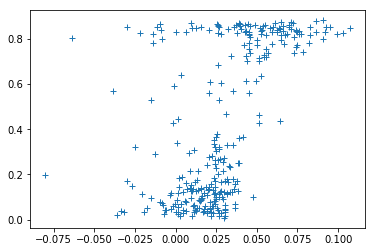

In [14]:
c = 'Lieutenant Governor'
differences = []
ethnicities = []
for p in data[c][0].keys():
    differences.append(data[c][0][p])
    ethnicities.append(data[c][1][p])
plt.plot(differences, ethnicities, '+')

In [15]:
[(precincts[i], differences[i], ethnicities[i]) 
 for i in range(len(differences)) if np.abs(differences[i])>0.2]

[]

In [16]:
fulton.loc[(fulton.Precinct_ID == "uc01b") & (fulton.Contest == c)]

,County,Precinct_ID,Vote type,Total ballots,Contest,Ballots cast,Undervotes
19337,FULTON,uc01b,Absentee by Mail,2,Lieutenant Governor,1,1
19338,FULTON,uc01b,Advance in Person 1,5,Lieutenant Governor,5,0
19339,FULTON,uc01b,Advance in Person 2,6,Lieutenant Governor,5,1
19340,FULTON,uc01b,Advance in Person 3,92,Lieutenant Governor,88,4
19341,FULTON,uc01b,Election Day,102,Lieutenant Governor,95,7
19342,FULTON,uc01b,Provisional,3,Lieutenant Governor,3,0
